MLP

Epoch [1/10] Loss: 0.8743
Epoch [2/10] Loss: 0.8297
Epoch [3/10] Loss: 0.8130
Epoch [4/10] Loss: 0.8021
Epoch [5/10] Loss: 0.7919
Epoch [6/10] Loss: 0.7844
Epoch [7/10] Loss: 0.7788
Epoch [8/10] Loss: 0.7722
Epoch [9/10] Loss: 0.7683
Epoch [10/10] Loss: 0.7634

✅ Test Accuracy: 0.7176029764889041

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.67      0.64     10454
           1       0.41      0.10      0.16      5954
           2       0.39      0.23      0.29      8528
           3       0.44      0.20      0.27     16131
           4       0.78      0.95      0.85     72624

    accuracy                           0.72    113691
   macro avg       0.53      0.43      0.44    113691
weighted avg       0.67      0.72      0.67    113691



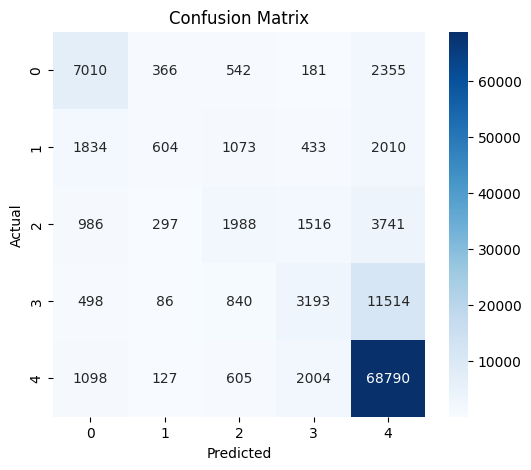

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# Load Data and Embeddings
# ============================================================
df = pd.read_csv("Reviews.csv", usecols=['Score'])
data = np.load("embeddings.npz")
X = data['embeddings']

# Target variable
y = df['Score'].astype(int)

# Optional: Map scores to 0–4 for classification
y = y - 1

# ============================================================
# Train-test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# Convert to tensors
# ============================================================
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# ============================================================
# Define Simple MLP Model
# ============================================================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=5):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# ============================================================
# Initialize model, loss, optimizer
# ============================================================
input_dim = X_train.shape[1]
num_classes = 5

model = MLPClassifier(input_dim=input_dim, hidden_dim=128, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ============================================================
# Training Loop
# ============================================================
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

# ============================================================
# Evaluation
# ============================================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(preds.tolist())

acc = accuracy_score(y_true, y_pred)
print("\n✅ Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Training Random Forest...
✅ Training complete!

✅ Test Accuracy: 0.7588

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.41      0.57     10454
           1       1.00      0.31      0.47      5954
           2       1.00      0.31      0.47      8528
           3       1.00      0.31      0.47     16131
           4       0.73      1.00      0.84     72624

    accuracy                           0.76    113691
   macro avg       0.93      0.47      0.56    113691
weighted avg       0.82      0.76      0.72    113691



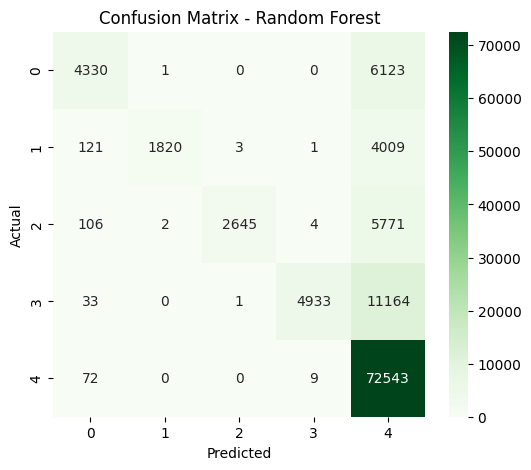

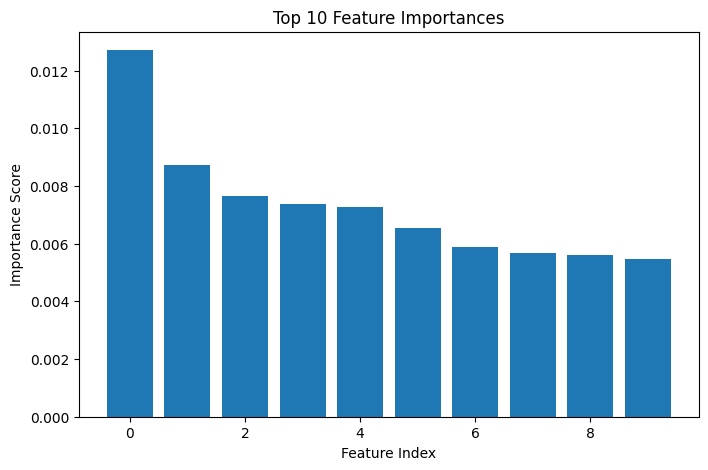

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# Load Data and Embeddings
# ============================================================
df = pd.read_csv("Reviews.csv", usecols=['Score'])
data = np.load("embeddings.npz")
X = data['embeddings']

# Target variable (convert scores 1–5 → 0–4 for better handling)
y = df['Score'].astype(int) - 1

# ============================================================
# Train-test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# Define and Train Random Forest Classifier
# ============================================================
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=20,           # limit depth to prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

print("Training Random Forest...")
rf.fit(X_train, y_train)
print("✅ Training complete!")

# ============================================================
# Evaluation
# ============================================================
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ============================================================
# Feature Importance Visualization
# ============================================================
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:][::-1]  # Top 10 features

plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()


Training Decision Tree...
✅ Training complete!

✅ Test Accuracy: 0.6952

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.48      0.49     10454
           1       0.43      0.34      0.38      5954
           2       0.46      0.35      0.40      8528
           3       0.51      0.36      0.42     16131
           4       0.78      0.87      0.82     72624

    accuracy                           0.70    113691
   macro avg       0.54      0.48      0.50    113691
weighted avg       0.67      0.70      0.68    113691



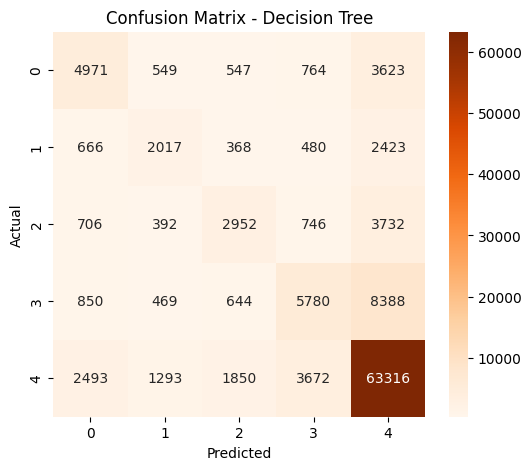

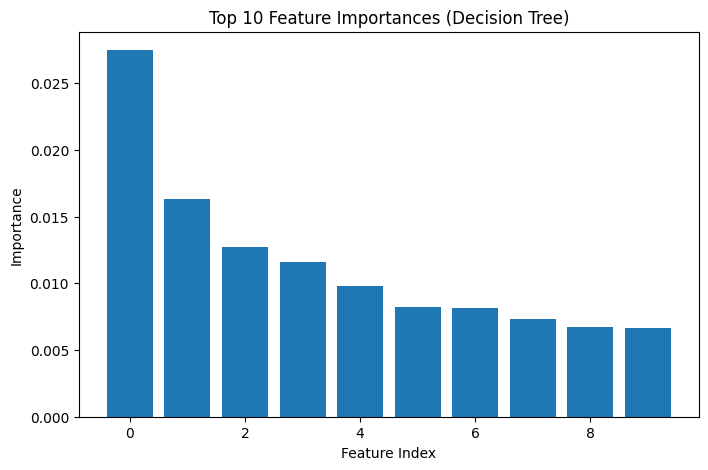

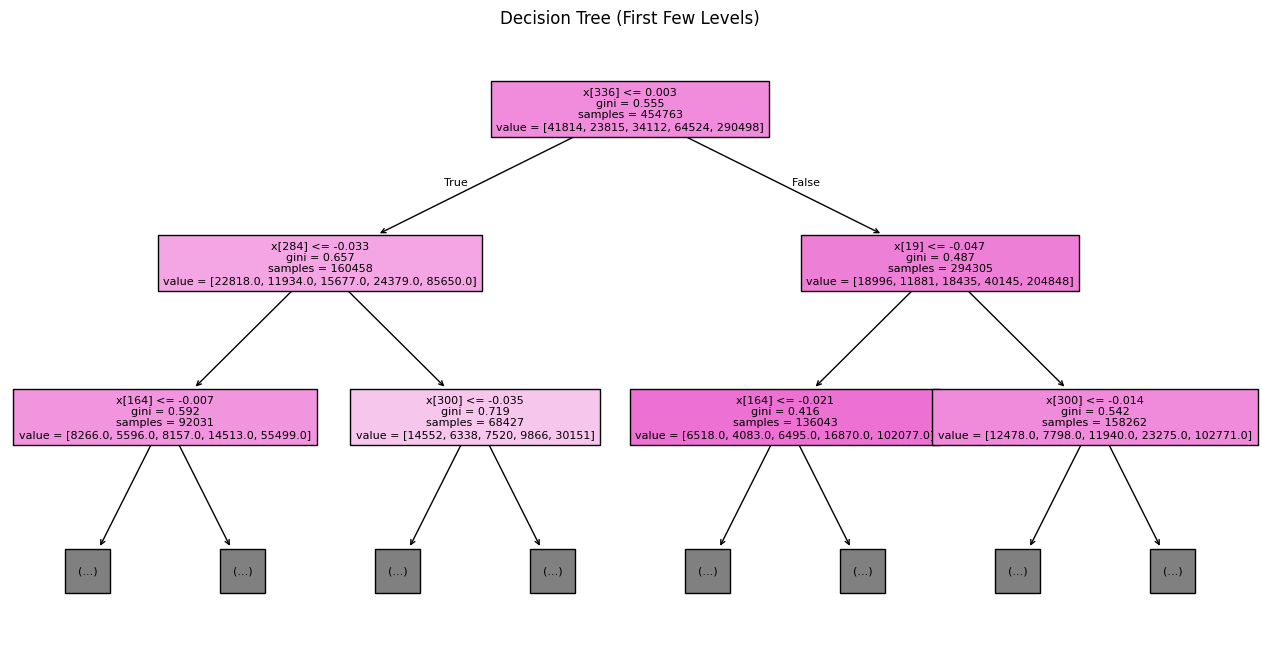

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# Load Data and Embeddings
# ============================================================
df = pd.read_csv("Reviews.csv", usecols=['Score'])
data = np.load("embeddings.npz")
X = data['embeddings']

# Target variable (convert 1–5 → 0–4)
y = df['Score'].astype(int) - 1

# ============================================================
# Train-test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# Define and Train Decision Tree Classifier
# ============================================================
dt = DecisionTreeClassifier(
    criterion='gini',       # or 'entropy'
    max_depth=20,           # limit depth to avoid overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

print("Training Decision Tree...")
dt.fit(X_train, y_train)
print("✅ Training complete!")

# ============================================================
# Evaluation
# ============================================================
y_pred = dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# ============================================================
# Feature Importance Visualization
# ============================================================
importances = dt.feature_importances_
indices = np.argsort(importances)[-10:][::-1]  # top 10 important features

plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# ============================================================
# Optional: Visualize a portion of the tree
# ============================================================
plt.figure(figsize=(16,8))
plot_tree(dt, max_depth=2, feature_names=None, filled=True, fontsize=8)
plt.title("Decision Tree (First Few Levels)")
plt.show()
